In [1]:
import os
import glob 

import numpy as np
import xarray as xr

import seaborn as sns

In [2]:
def get_list_of_files(start = '2014-01-01', stop = '2018-12-31', include_start = True, include_stop = True, path_input = None):
    print('enters, searching in directory {}'.format(path_input))
    # Remove date.
    parts = start.split('-')
    start_search_str = '{}_{:02d}'.format(parts[0], int(parts[1]))

    if stop is not None:
        parts = stop.split('-')
        stop_search_str = '{}_{:02d}'.format(parts[0], int(parts[1]))
    else:
        stop_search_str = ''

    if (start_search_str == stop_search_str) or (stop is None):
        subset = glob.glob(os.path.join( path_input, '{}*.nc'.format(start_search_str)))
    else:
        # get all files
        files = glob.glob(os.path.join( path_input, '*.nc' ))
        files = np.sort(files) # sorting then for no particular reson

        if include_start and include_stop:
            min_fil = os.path.join(path_input, start_search_str + '_q.nc')
            max_fil = os.path.join(path_input, stop_search_str + '_tcc.nc')

            smaller = files[files <= max_fil]
            subset  = smaller[smaller >= min_fil] # results in all the files

        elif include_start and not include_stop:
            min_fil = os.path.join(path_input, start_search_str + '_q.nc')
            max_fil = os.path.join(path_input, stop_search_str + '_q.nc')

            smaller = files[files < max_fil]
            subset  = smaller[smaller >= min_fil] # results in all the files

        elif not include_start and include_stop:
            min_fil = os.path.join(path_input, start_search_str + '_tcc.nc')
            max_fil = os.path.join(path_input, stop_search_str + '_tcc.nc')

            smaller = files[files <= max_fil]
            subset  = smaller[smaller > min_fil] # results in all the files
        else:
            raise ValueError('Something wierd happend. ')
    return subset


# PLOT MAE best ConvLSTM grid

In [6]:
def mean_absolute_error(y_true, y_pred):
    mse = np.nanmean(np.abs(np.subtract(y_true, y_pred)), axis = 0)
    return mse

# Load prediction 

In [7]:
model = 'ConvLSTM-B10-SL24-32-3x3-32-3x3'

In [8]:
glob.glob('/home/hanna/EX3_Results/{}/prediction.nc'.format(model))

['/home/hanna/EX3_Results/ConvLSTM-B10-SL24-32-3x3-32-3x3/prediction.nc']

In [9]:
data_prediction = xr.open_dataset('/home/hanna/EX3_Results/ConvLSTM-B10-SL24-32-3x3-32-3x3/prediction.nc')

In [10]:
data_prediction

<xarray.Dataset>
Dimensions:          (batch: 1820, latitude: 81, longitude: 161, sequence_length: 24)
Coordinates:
  * batch            (batch) int64 0 1 2 3 4 5 ... 1814 1815 1816 1817 1818 1819
  * latitude         (latitude) float64 30.0 30.25 30.5 ... 49.5 49.75 50.0
  * longitude        (longitude) float64 -15.0 -14.75 -14.5 ... 24.5 24.75 25.0
  * sequence_length  (sequence_length) int64 0 1 2 3 4 5 6 ... 18 19 20 21 22 23
Data variables:
    date_seq         object ...
    tcc              (batch, sequence_length, latitude, longitude) float64 ...

# Load target 

In [11]:
target_files = get_list_of_files(start = '2014-01-01', 
                               stop = '2018-12-31', 
                                include_start = True, 
                               include_stop = True, 
                               path_input = '/home/hanna/lagrings/ERA5_monthly/')

enters, searching in directory /home/hanna/lagrings/ERA5_monthly/


In [12]:
len(target_files)

300

In [13]:
#lh_files = glob.glob('/home/hanna/lagrings/ERA5_monthly/*2014*01*tcc.nc')
input_data = xr.open_mfdataset(target_files, combine='by_coords')

In [14]:
input_data

<xarray.Dataset>
Dimensions:        (latitude: 81, longitude: 161, time: 43824)
Coordinates:
  * latitude       (latitude) float64 30.0 30.25 30.5 30.75 ... 49.5 49.75 50.0
  * time           (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00
  * longitude      (longitude) float64 -15.0 -14.75 -14.5 ... 24.5 24.75 25.0
    isobaricInhPa  int64 1000
    number         int64 0
    step           timedelta64[ns] 00:00:00
    valid_time     (time) datetime64[ns] dask.array<chunksize=(744,), meta=np.ndarray>
    surface        int64 0
Data variables:
    tcc            (time, latitude, longitude) float64 dask.array<chunksize=(744, 81, 161), meta=np.ndarray>
    nr_nans        (time, latitude, longitude) float64 dask.array<chunksize=(744, 81, 161), meta=np.ndarray>
    q              (time, latitude, longitude) float32 dask.array<chunksize=(744, 81, 161), meta=np.ndarray>
    r              (time, latitude, longitude) float32 dask.array<chunksize=(744, 81, 161), meta=np.ndarray>
    sp             (time, latitude, longitude) float32 dask.array<chunksize=(744, 81, 161), meta=np.ndarray>
    t2m            (time, latitude, longitude) float32 dask.array<chunksize=(744, 81, 161), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-02-20T09:59:12 GRIB to CDM+CF via cfgrib-0....

# Compute MAE 

In [ ]:
prediction = np.ones((1820, 81, 161))
for i in range(1820):
    subset_loss  = data_prediction.isel(batch=i)
    subset_input = input_data.isel(time=slice(i*24, (i+1)*24) )
    prediction[i, :, :] = np.nansum(np.abs(np.subtract(subset_loss.tcc.values, subset_input.tcc.values)), axis = 0)
    print('finished {}'.format(i))

finished 0
finished 1
finished 2
finished 3
finished 4
finished 5
finished 6
finished 7
finished 8
finished 9
finished 10
finished 11
finished 12
finished 13
finished 14
finished 15
finished 16
finished 17
finished 18
finished 19
finished 20
finished 21
finished 22
finished 23
finished 24
finished 25


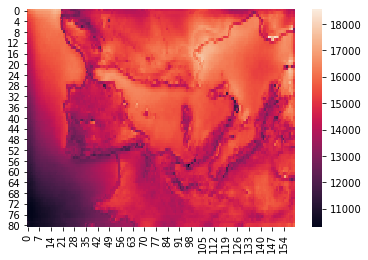

In [20]:
sns.heatmap(prediction.sum(axis=0))

# Store MAE BEST GRID FOR PLOT

In [21]:
data_dict = {'mae_test': (['latitude', 'longitude'], prediction.sum(axis=0))}

longitude  = np.arange(-15.0, 25.0+0.25, step = 0.25)
latitude   =  np.arange(30.0, 50.0+0.25, step = 0.25)

ds = xr.Dataset(data_dict,
         coords={'longitude': (['longitude'], longitude),
                 'latitude': (['latitude'], latitude),
                 'sequence_length': (['sequence_length'], np.arange(24))
                })
ds['date_seq']  = '2014-01-01'
ds['name'] = 'ConvLSTM-B10-SL24-32-3x3-32-3x3'
print(ds)
ds.to_netcdf(os.path.join('/home/hanna/MS-thesis/python_figs/','mae_convlstm_best_model_mean.nc'))


<xarray.Dataset>
Dimensions:          (latitude: 81, longitude: 161, sequence_length: 24)
Coordinates:
  * longitude        (longitude) float64 -15.0 -14.75 -14.5 ... 24.5 24.75 25.0
  * latitude         (latitude) float64 30.0 30.25 30.5 ... 49.5 49.75 50.0
  * sequence_length  (sequence_length) int64 0 1 2 3 4 5 6 ... 18 19 20 21 22 23
Data variables:
    mae_test         (latitude, longitude) float64 1.578e+04 ... 1.584e+04
    date_seq         <U10 '2014-01-01'
    name             <U31 'ConvLSTM-B10-SL24-32-3x3-32-3x3'


# Store MAE ER5

In [36]:
data = xr.open_dataset(os.path.join('/home/hanna/MS-thesis/python_figs/', 'mae_target_vs_era5.nc'))

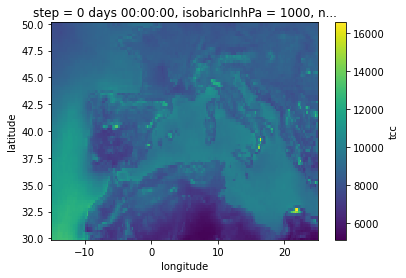

In [39]:
data['tcc'].plot()

In [ ]:
data_dict = {'mae_test': (['latitude', 'longitude'], prediction)}

longitude  = np.arange(-15.0, 25.0+0.25, step = 0.25)
latitude   =  np.arange(30.0, 50.0+0.25, step = 0.25)

ds = xr.Dataset(data_dict,
         coords={'longitude': (['longitude'], longitude),
                 'latitude': (['latitude'], latitude),
                 'sequence_length': (['sequence_length'], np.arange(24))
                })
ds['date_seq']  = '2014-01-01'
ds['name'] = 'ConvLSTM-B10-SL24-32-3x3-32-3x3'
print(ds)
ds.to_netcdf(os.path.join('/home/hanna/MS-thesis/python_figs/','mae_era5_best_model.nc'))
